# Probabilistic ML: Assignment 2
- **Deadline**: Feb 16, 23:59 ET
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.



# Q1 - Image Denoising

In this problem, we will implement the max-product Loopy **belief propagation** (Loopy-BP) method for denoising binary images which you have seen in tutorial 4.
We will consider images as matrices of size $\sqrt{n} \times \sqrt{n}$. Each element of the matrix can be either $1$ or $-1$, with $1$ representing white pixels and $-1$ representing black pixels. This is different from the $0/1$ representation commonly used for other CV tasks. This notation will be more convenient when multiplying with pixel values.

### Data preparation
Below we provide you with code for loading and preparing the image data.

First, we load a black and white image and convert it into a binary matrix of 1 and -1. So that white pixels have value 1 and black pixels have value -1.

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7af2eddf370b6ef36a7fa652d611dc92126c1c488ff40fe20552942ea49639ab
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


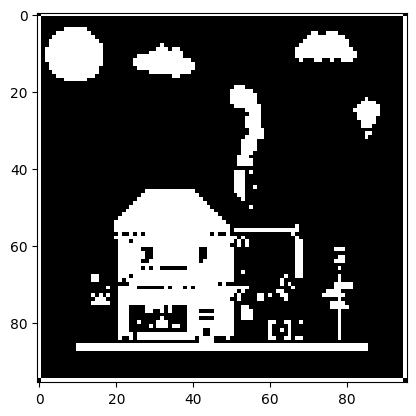

In [ ]:
!pip install wget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image as Image
from os.path import exists
from wget import download
from tqdm import tqdm

filename, url = "trc1l3gqu9651.png", "https://i.redd.it/trc1l3gqu9651.png"

def load_img():
    if not exists(filename):
        download(url)

    with open(filename, 'rb') as fp:
        img2 = Image.open(fp).convert('L')
        img2 = img2.resize((96, 96), Image.LANCZOS)
        img2 = np.array(img2)
    return (img2 > 120) * 2.0 - 1

img_true = load_img()
plt.imshow(img_true, cmap='gray')

To introduce noise into the image, for each pixel, swap its value between 1 and -1 with rate 0.2.


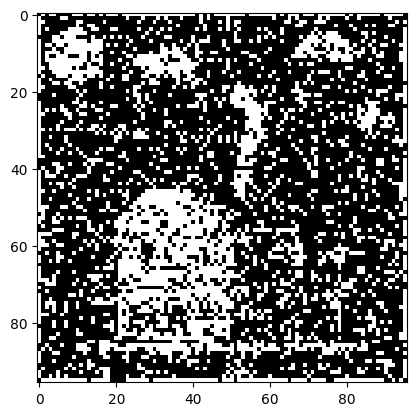

In [ ]:
def gen_noisyimg(img, noise=.05):
    swap = np.random.binomial(1, noise, size=img.shape)
    return img * (1 - 2 * swap)

noise = 0.2
img_noisy = gen_noisyimg(img_true, noise)
plt.imshow(img_noisy, cmap='gray')

### The Loopy BP algorithm


Recall from lecture and tutorial, the Loopy-BP algorithm iteratively updates the messages of each node through a sum-product or max-product operation. The sum-product operation computes the joint inbound message through multiplication, and then marginalizes the factors through summation. This is in contrast to the max-product BP, which computes the maximum a-posteriori (MAP) value for each variable through taking the maximum over variables. In this question, we will implement the **max-product** BP to obtain the MAP estimate

Initialization:

For discrete node $x_j$ with $2$ possible states, $m_{i \rightarrow j}$ can be written as a $2$ dimensional real vector $\mathrm{m}_{i,j}$ with $m_{i \rightarrow j}(x_j) =  \mathrm{m}_{i,j}[index(x_j)]$. We initialize them uniformly to $m_{i \rightarrow j}(x_j) = 1/2$.

(Aside: for continuous cases, $m_{i \rightarrow j}(x_j)$ is a real valued function of $x_j$. We only need to deal with the discrete case here.)

For a number of iterations:

&nbsp;&nbsp;&nbsp;&nbsp;For node $x_j$ in $\{x_s\}_{s=1}^n$:  
1. Compute the product of inbound messages from neighbours of $x_j$:
$$\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)$$

2. Compute potentials $\psi_j(x_j) = \exp (\beta x_j y_j)$ and $\psi_{ij}(x_i,x_j) = \exp(J x_i x_j)$. This expression specifically holds when $x \in \{-1,+1\}$.

3. Maximize over $x_j = \{-1, +1\}$ to get $m_{j \rightarrow i}(x_i)$:
$$
m_{j \rightarrow i}(x_i) = \max_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
4. Normalize messages for stability $m_{j \rightarrow i}(x_i) =m_{j \rightarrow i}(x_i)/\sum_{x_i}m_{j \rightarrow i}(x_i)$.

Compute beliefs after message passing is done.
$$
b(x_i) \propto \psi_i(x_i) \prod_{j \in N(i)} m_{j \rightarrow i}(x_i).
$$


You'll be tasked to perform steps 1-3 in the iterations and computing the beliefs. We will provide you with helper functions for initialization, finding neighbours, and normalization.

### Initialization
Initialize the message between neighbor pixels uniformly as $m_{j→i}(x_i) = 1/k$. Since each pixel can only be 1 or -1, message has two values $m_{j→i}(1)$ and $m_{j→i}(-1)$. We also initialize hyperparameters $J$ and $\beta$.

In [ ]:
y = img_noisy.reshape([img_true.size, ])
num_nodes = len(y)
init_message = np.zeros([2, num_nodes, num_nodes]) + .5
J = 1.0
beta = 1.0

Find the neighboring pixels around a given pixel, which will be used for BP updates

In [ ]:
def get_neighbors_of(node):
    """
    arguments:
     int node:  in [0,num_nodes) index of node to query
    globals:
     int num_nodes: number of nodes
    return: set(int) indices of neighbors of queried node
    """
    neighbors = []
    m = int(np.sqrt(num_nodes))
    if (node + 1) % m != 0:
        neighbors += [node + 1]
    if node % m != 0:
        neighbors += [node - 1]
    if node + m < num_nodes:
        neighbors += [node + m]
    if node - m >= 0:
        neighbors += [node - m]

    return set(neighbors)

## Q1.1 Implement message passing in BP [20 points]

Implement the function `get_message()` that computes the message passed from node j to node i: $$
m_{j \rightarrow i}(x_i) = \max_{x_j}\psi_j(x_j)\psi_{ij}(x_i, x_j)\prod_{k \in N(j) \not = i} m_{k \rightarrow j}(x_j)
$$
`get_message()` will be used by (provided below) `step_bp()` to perform one iteration of loopy-BP: it first normalizes the returned message from `get_message()`, and then updates the message with momentum `1.0 - step`.

In [ ]:
def get_message(node_from, node_to, messages):
    """
    arguments:
     int node_from: in [0,num_nodes) index of source node
     int node_from: in [0,num_nodes) index of target node
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float array y: (num_nodes,) observed pixel values
     float J: clique coupling strength constant
     float beta: observation to true pixel coupling strength constant
    return: array(float) of shape (2,) un-normalized message from node_from to
    node_to
    """
    #TODO: implement your function here
    x_value = np.array([1, -1])
    psi_j = np.exp(beta * y[node_from] * x_value)

    neighbors = get_neighbors_of(node_from)
    neighbors.remove(node_to)

    message_passing = np.array((1, 1))
    for n in neighbors:
      message_passing = message_passing * messages[:, n, node_from]

    message = np.zeros(2)
    for i in range(len(x_value)):
      x_i = x_value[i]
      psi_ij = np.exp(J * x_i * x_value)
      message[i] = np.max(psi_j * psi_ij * message_passing)

    return message


def step_bp(step, messages):
    """
    arguments:
     float step: step size to update messages
    return
     float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    """
    for node_from in range(num_nodes):
        for node_to in get_neighbors_of(node_from):
            m_new = get_message(node_from, node_to, messages)
            # normalize
            m_new = m_new / np.sum(m_new)

            messages[:, node_from, node_to] = step * m_new + (1. - step) * \
                messages[:, node_from, node_to]
    return messages

Then, run loopy BP update for 10 iterations:

In [ ]:
num_iter = 10
step = 0.5
for it in range(num_iter):
    init_message = step_bp(step, init_message)
    print(it + 1,'/',num_iter)

1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## Q1.2 Computing belief from messages [10 points]

Now, calculate the unnormalized belief for each pixel
$$ \tilde{b}(x_i) = \psi_i(x_i) ∏_{j \in N(i)}m_{j→i}(x_i),$$
and normalize the belief across all pixels
$$ b(x_i) = \frac{\tilde{b}(x_i)}{∑_{x_j}\tilde{b}(x_j)}.$$

In [ ]:
def update_beliefs(messages):
    """
    arguments:
    float array messages: (2, num_nodes, num_nodes), messages[:,j,i] is message
                           from node j to node i
    reads globals:
     float beta: observation to true pixel coupling strength constant
     float array y: (num_nodes,) observed pixel values
    returns:
     float array beliefs: (2, num_nodes), beliefs[:,i] is the belief of node i
    """
    beliefs = np.zeros((2, num_nodes))

    for node in range(num_nodes):
        #TODO: implement belief calculation here
        psi_i = np.exp(beta * y[node] * np.array([1, -1]))
        node_from = get_neighbors_of(node)
        prod_message = np.prod([get_message(n, node, messages) for n in node_from], axis=0)
        beliefs[:, node] = psi_i * prod_message
    beliefs = beliefs / np.sum(beliefs, axis=0)

    return beliefs

# call update_beliefs() once
beliefs = update_beliefs(init_message)

Finally, to get the denoised image, we use 0.5 as the threshold and consider pixel with belief less than threshold as black while others as white, which is the same as choosing the pixel with maximum probability

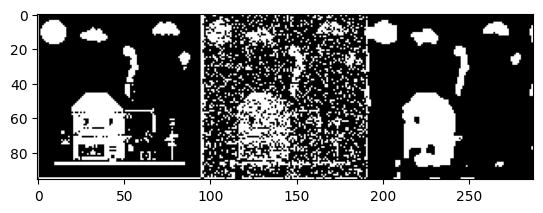

In [ ]:
pred = 2. * ((beliefs[0, :] > .5) + .0) - 1.
img_out = pred.reshape(img_true.shape)

plt.imshow(np.hstack([img_true, img_noisy, img_out]), cmap='gray')

## Q1.3 Momentum in belief propagation [10 points]
In the sample code provided above, we performed message update with a momentum parameter `step`. In this question, you will experimentally investigate how momentum affects the characteristics of convergence.




### Q1.3.a [5 points]
Complete the function `test_trajectory` below to obtain predicted image after each step of message passing. Return predicted images as list.

In [ ]:
def test_trajectory(step_size, max_step=10):
    """
    step_size: step_size to update messages in each iteration
    max_step: number of steps
    """
    # re-initialize each time
    messages = np.zeros([2, num_nodes, num_nodes]) + .5
    images = []

    # solution:
    for _ in range(max_step):
      init_message = step_bp(step_size, messages)
      beliefs = update_beliefs(init_message)
      pred = 2. * ((beliefs[0, :] > .5) + .0) - 1.
      img_out = pred.reshape(img_true.shape)
      images.append(img_out)

    return images

### Q1.3.b [5 points]
Use test trajectory to create image serieses for `step size` 0.1, 0.3, and 1.0, each with 10 steps. Display these images with `plot_series' provided below.

In the textbox below: 1. Comment on what happens when a large step size is used for too many iterations. 2. How would you adjust other hyperparameters to counteract this effect?

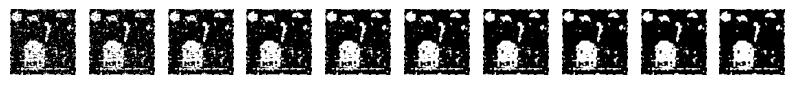

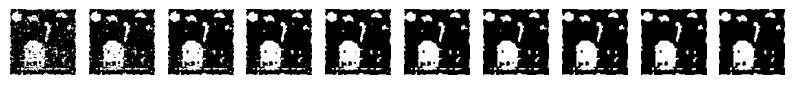

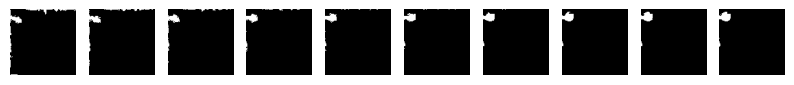

In [ ]:
def plot_series(images):
  n = len(images)
  fig, ax = plt.subplots(1, n)
  for i in range(n):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_axis_off()
  fig.set_figwidth(10)
  fig.show()

#Solution:
step_size = [0.1, 0.3, 1.0]
for s in step_size:
  images = test_trajectory(s, 10)
  plot_series(images)



### Response to 1.3.b (Enter your response below):

1. A larger step size over too many iterations makes the message updating prosee too aggressive with significant loss of detail.

2. To achieve a more accurate generated image, we should use a smaller step size and adjust other hyperparameters such as J and $\beta$.
- A smaller step size allows for a more gradual and stable transformation, preserving details and reducing noise.
- A smaller J would counteract this effect by preventing the updating process become too aggressive as it controls how similar each pixel should be compared to its neighbors.
- A larger $\beta$ would counteract this effect, because a higher beta strenghen the influence of the observations, which helps stablize the updates when step size is large.

## Q1.4 Noise level and the hyperparameter $J$ [10 points]
In this question, we will study how the level of noise in the image influences our choice in the hyperparameter $J$.

### Q1.4.a [5 points]
First, generate and display images with noise of $0.05$, $0.3$.
In the text box below, comment on what would happen if noise was set to $0.5$ and $1.0$

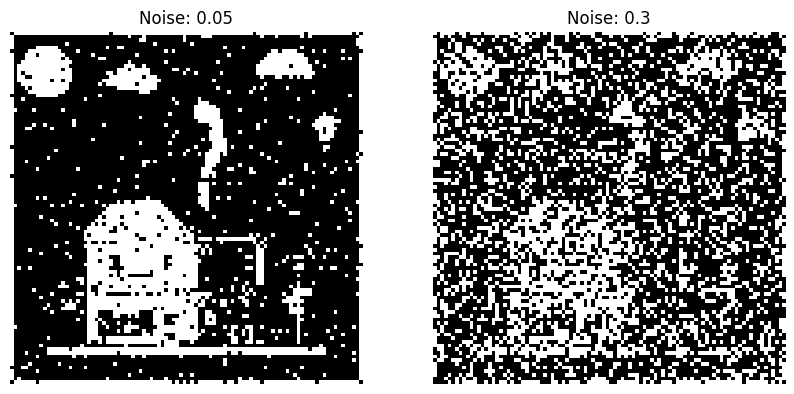

In [ ]:
# Solution
noise = [0.05, 0.3]
fig, axes = plt.subplots(1, len(noise), figsize=(10, 5))

for ax, n in zip(axes, noise):
    img_noisy = gen_noisyimg(img_true, n)
    ax.imshow(img_noisy, cmap='gray')
    ax.set_title(f"Noise: {n}")
    ax.axis('off')

plt.show()

### Response to 1.4.a (enter your response below):
Solution:

- When noise is 0.5, all the pixels have the probability of 50% being flipped. Thus, the image is pure noise.
- When noise is 1, all the pixels are flipped. So, the image is the same with the inverted color of the original one.

### Q1.4.b [5 points]
Now, perform image denoising on images with noise levels $0.05$ and $0.3$ using $J=0.1$, $J=0.5$, $J=1.0$, and $J=5.0$. Set step size to 0.8 and max_step to 5. Plot the denoised images (if reusing `test_trajectory`, you should plot 8 image serieses).
In text box below, comment on what you observe and provide a brief explanation on why this might occur.

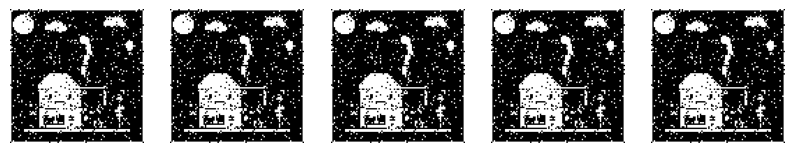

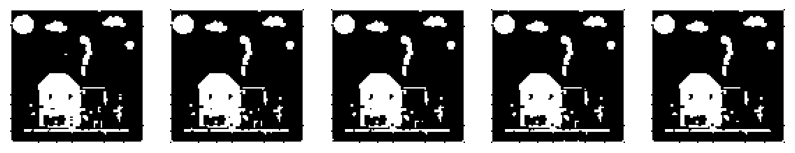

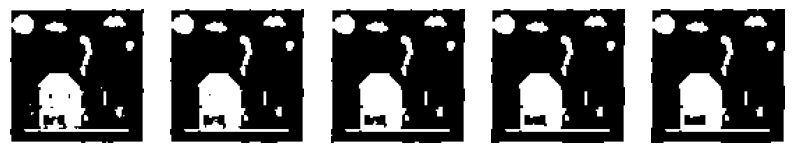

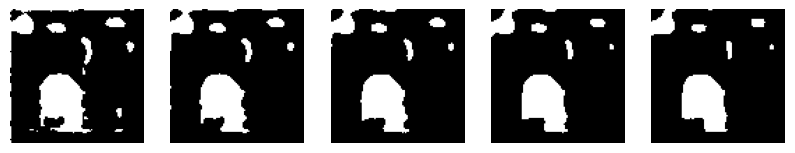

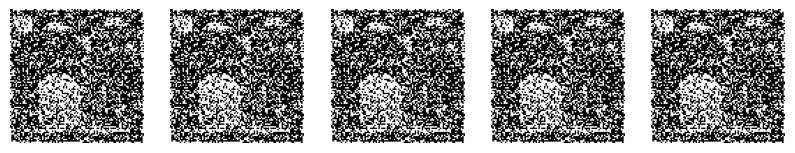

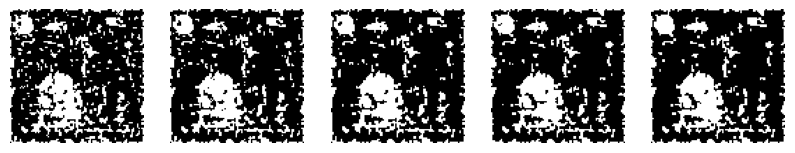

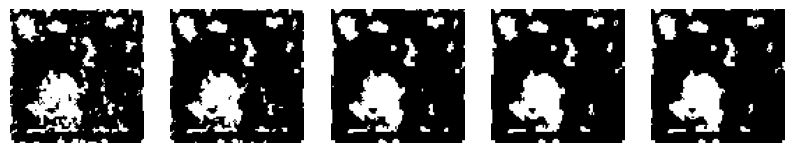

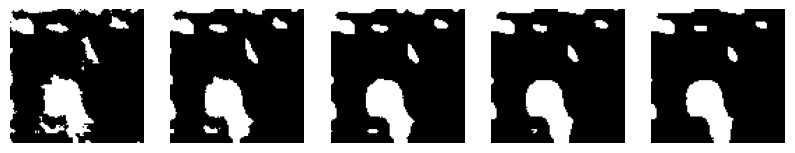

In [ ]:
# Solution
beta = 1.0
step = 0.8
max_step = 5
J_lst = [0.1, 0.5, 1.0, 5.0]
noise_lst = [0.05, 0.3]

for noise in noise_lst:
  for J in J_lst:
    img_noisy = gen_noisyimg(img_true, noise)
    y = img_noisy.reshape([img_true.size, ])
    images = test_trajectory(step, max_step)
    plot_series(images)


### Response to 1.4.b (enter your response below):


From the picture generated above, we can observe that when noise=0.05, J=0.1 generates the image which is closest to the true image. When noise=0.3, higher J such as J=1 tends to generate image which is closer to the true image.

- With small noise, a small J is ideal. Smaller J helps preserve details while removing minor noise by avoiding produce clusters of the same color.
- When noise level is high, higher J tends to work well. Because when noise is high, the black and white pixels are mixing together, which makes the image undistinguishable. As J controls how similar each pixel should be compared to its neighbors, larger J helps generalize the pixels, making it much clearer and smooth. However, when J is too large, it would result in over-smoothing.